1000 sample from distribution
create function from distributions
create function 
```python
def fun(df, bins):
```
also use pytnon dictionaries
```python
dict = {'N(0,1)', np.radnom.normal(0,1,size)}
```
where
```python
df = pd.DataFram(dict)
```

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def plotFaceGrid(df, _bins=10, _cumulative=False):
    """
    This function plots 
    """
    df = df.melt()
    df.head()
    g = sns.FacetGrid(df, col="variable", col_wrap=3, sharex=False)
    g = g.map(plt.hist, "value", bins=_bins, cumulative=_cumulative)

In [3]:
size = 10000

normal_dist = {
    'N(0:1)': np.random.normal(0, 1, size),
    'N(10:2)': np.random.normal(10, 2, size),
    'N(10:30)': np.random.normal(10, 30, size),
    'N(20:30)': np.random.normal(22, 30, size),
    'N(0:13)': np.random.normal(0, 13, size)
}
df = pd.DataFrame(normal_dist)
df.head()

,N(0:1),N(10:2),N(10:30),N(20:30),N(0:13)
0,0.839346,9.832157,-9.217638,46.410757,23.034659
1,-0.925531,11.819965,68.758913,24.076676,-13.641481
2,0.042029,10.005698,-27.541333,12.191559,14.944823
3,0.194244,12.148094,33.567021,18.049840,-3.790803
4,-2.428471,9.950545,26.765051,-1.382029,-1.681118


## Normal 

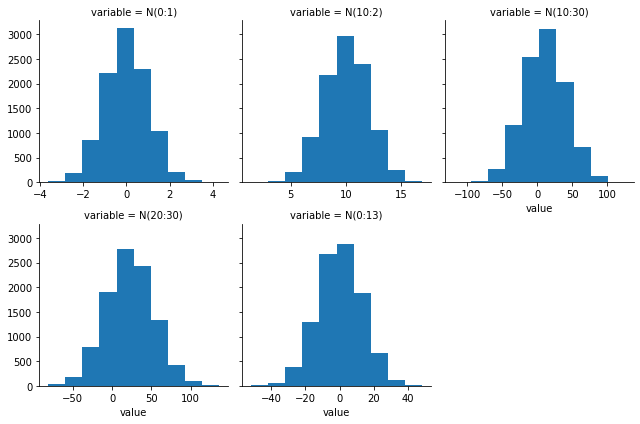

In [4]:
plotFaceGrid(df)

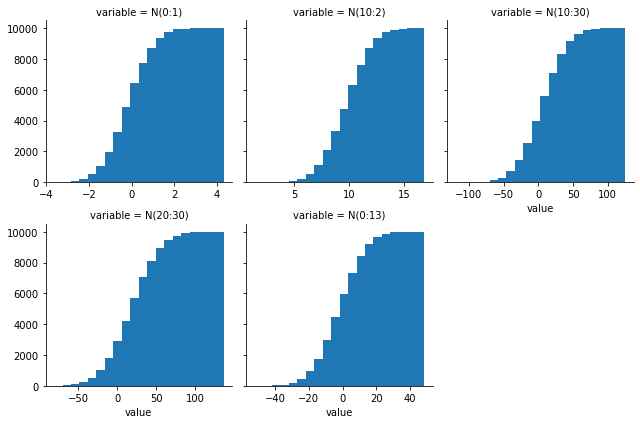

In [5]:
plotFaceGrid(df, _bins=20, _cumulative=True)

## Logit

In [6]:
import scipy as sp

In [7]:
logit_dist = normal_dist
for key, value in logit_dist.items():
    logit_dist[key] = sp.special.expit(value)

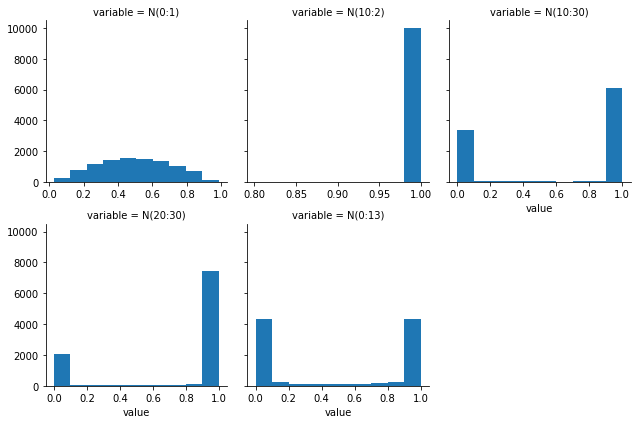

In [8]:
plotFaceGrid(pd.DataFrame(logit_dist))

## Poisson

In [9]:
poisson_dist = {
    'P(0.1)': np.random.poisson(0.1, size),
    'P(0.2)': np.random.poisson(0.2, size),
    'P(0.3)': np.random.poisson(0.3, size),
    'P(0.7)': np.random.poisson(0.7, size),
    'P(0:13)': np.random.poisson(0.13, size) 
}

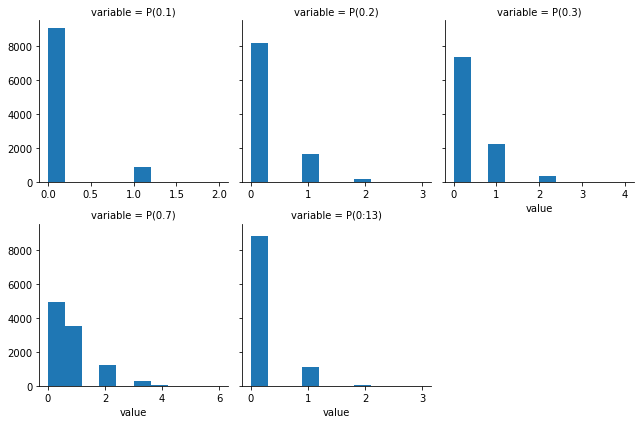

In [10]:
plotFaceGrid(pd.DataFrame(poisson_dist))

## Beta

In [11]:
def get_mean(alpha, beta):
    return alpha/(alpha + beta)

def get_var(alpha, beta):
    temp = get_mean(alpha, beta)
    return temp*(1-temp)*1.0/(alpha+beta+1)

In [12]:
beta_dist = {
    'B(1:1)': np.random.beta(1, 1, size),
    'B(10:.2)': np.random.beta(10, .2, size),
    'B(10:30)': np.random.beta(10, 30, size),
    'B(20:30)': np.random.beta(22, 30, size),
    'B(1:13)': np.random.beta(1, 13, size) 
}

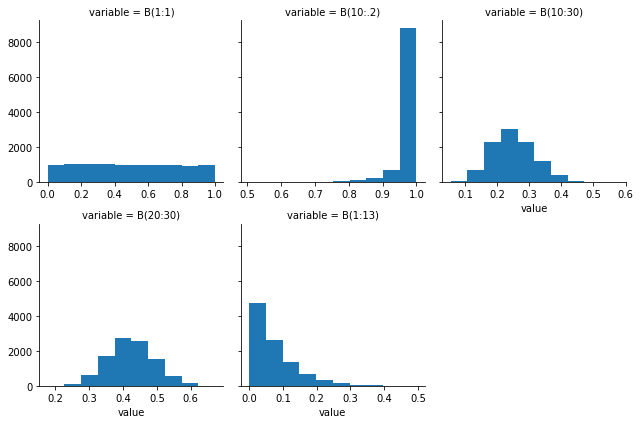

In [13]:
plotFaceGrid(pd.DataFrame(beta_dist))

## Lognormal

In [14]:
lognormal_dist = {
    'L(0:1)': np.random.lognormal(0, 1, size),
    'L(10:2)': np.random.lognormal(10, 2, size),
    'L(3:1)': np.random.lognormal(3, 1, size),
    'L(20:30)': np.random.lognormal(22, 30, size),
    'L(0:13)': np.random.lognormal(0, 13, size)
}

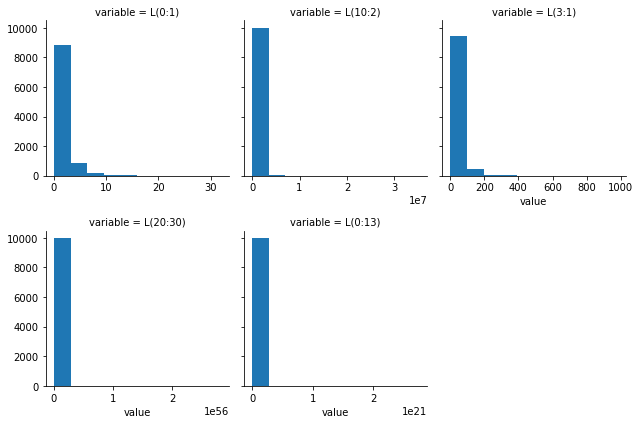

In [15]:
plotFaceGrid(pd.DataFrame(lognormal_dist))

# Stan

In [16]:
import utils.stan_utility as stan_utility
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import seaborn as sns
import pandas as pd

import scipy.stats as stats
from scipy.stats import kde

In [17]:
import matplotlib.pyplot as plt
import matplotlib as mpl

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

### 1. Gamma family

In [18]:
with open('stan_model/gamma.stan') as file:
    print(file.read())

data {
    real alpha;
    real beta;
}

generated quantities {
    real gamma = gamma_rng(alpha, beta);
    real inv_gamma = inv_gamma_rng(alpha, beta);
}



In [19]:
gamma_model = stan_utility.compile_model('stan_model/gamma.stan')

Using cached StanModel


In [20]:
sim = gamma_model.sampling(data={'alpha': 3, 'beta': 2},
                          algorithm="Fixed_param",
                          iter=1000,
                          warmup=0,
                          chains=1,
                          seed=25052020)

In [21]:
params=sim.extract()
gamma=params['gamma']
inv_gamma=params['inv_gamma']

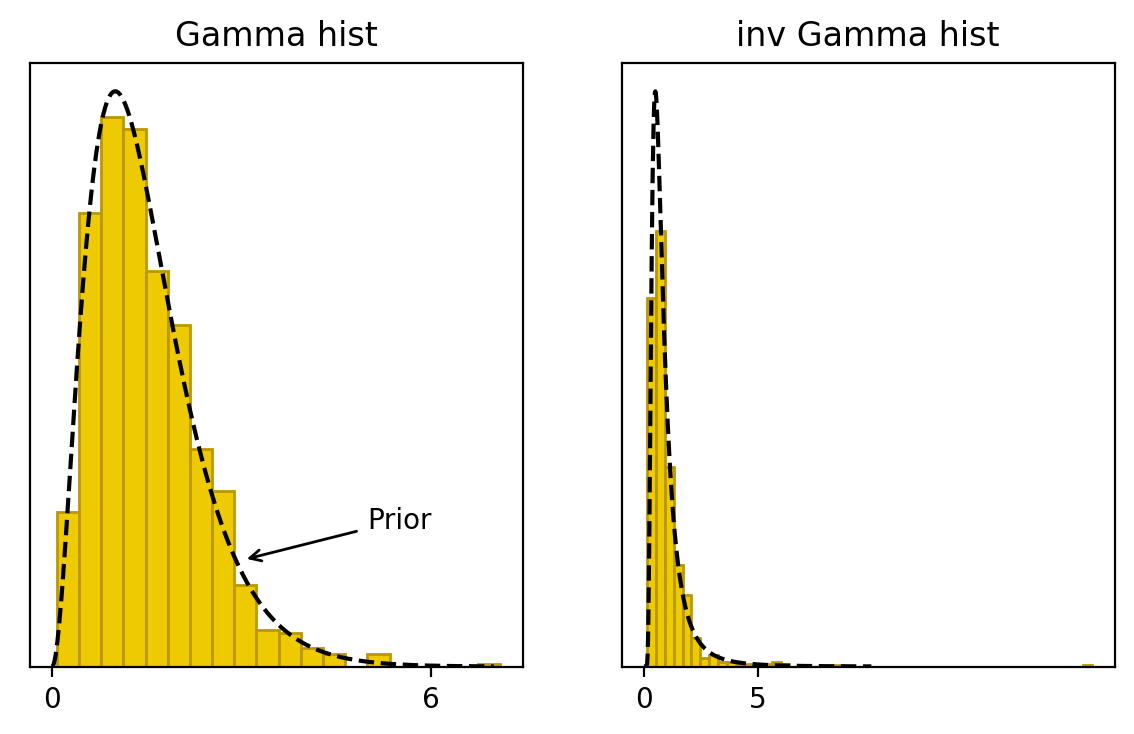

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))
ax1=axes[0]
ax1.hist(gamma,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,7,500)
alpha = 3
beta = 2
ax1.plot(x,stats.gamma.pdf(x,a=alpha,scale=1/beta),color='black',linestyle='--')
ax1.set_xticks([0,6])
ax1.set_yticks([])
ax1.set_title(r'Gamma hist')
ax1.annotate('Prior',xy=(3,0.1),xytext=(5,0.13),arrowprops={'arrowstyle':'->'})

ax2=axes[1]
ax2.hist(inv_gamma,bins=50,color=dark,edgecolor=dark_highlight,density=True)
x2=np.linspace(0,10,500)
ax2.plot(x2,stats.invgamma.pdf(x2,a=alpha,scale=beta),color='black',linestyle='--')
ax2.set_yticks([])
ax2.set_xticks([0,5])
ax2.set_title('inv Gamma hist')
plt.show()

In [23]:
with open('stan_model/gamma_tune.stan') as file:
    print(file.read())

functions {
    vector gammaUnknown (vector y, vector theta, real[] x_r, int[] x_i) {
        vector[3] gammas;
        gammas[1] = gamma_cdf(theta[1], exp(y[1]), exp(y[2])) - exp(y[3]);
        gammas[2] = gamma_cdf(theta[2], exp(y[1]), exp(y[2])) - exp(y[3]) - 0.98;
        gammas[3] = exp(y[1])/exp(y[2]) - 7;
        return gammas;
    }
}

data {
    real lowerBound;
    real upperBound;
    real alphaGuess;
    real betaGuess;
    real probGuess;
}

transformed data {
    vector[3] y;
    real x_r[0];
    int x_i[0];
    vector[2] theta = [lowerBound, upperBound]';
    vector[3] y_guess = [log(alphaGuess), log(betaGuess), log(probGuess)]';
    y = algebra_solver(gammaUnknown, y_guess, theta, x_r, x_i);
}

generated quantities {
    real alpha = exp(y[1]);
    real beta = exp(y[2]);
}



In [24]:
gamma_tuning=stan_utility.compile_model('stan_model/gamma_tune.stan')

Using cached StanModel


In [25]:
data=dict(lowerBound=5, upperBound=10, alphaGuess=8, betaGuess=1, probGuess=0.09)
tuned = gamma_tuning.sampling(data=data,
                                seed=1052020,
                                algorithm="Fixed_param",
                                iter=1000, 
                                warmup=0,
                                chains=1)

In [26]:
alpha = np.round(tuned.extract()['alpha'][0])
beta = np.round(tuned.extract()['beta'][0])
print(f'alpha: {alpha}\tbeta: {beta}')

alpha: 47.0	beta: 7.0


In [27]:
sim = gamma_model.sampling(data={'alpha': alpha, 'beta': beta},
                          algorithm="Fixed_param",
                          iter=1000,
                          warmup=0,
                          chains=1,
                          seed=25052020)

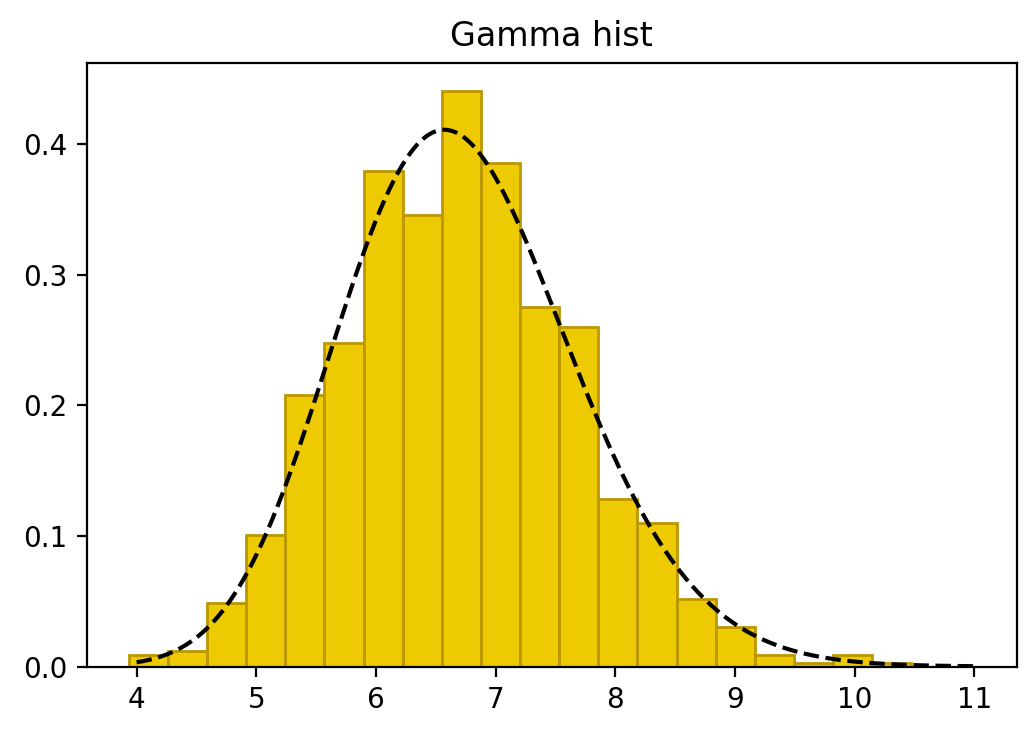

In [28]:
params=sim.extract()
gamma=params['gamma']

plt.hist(gamma,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(4,11,500)
plt.plot(x,stats.gamma.pdf(x,a=alpha,scale=1/beta),color='black',linestyle='--')
plt.title(r'Gamma hist')
plt.annotate('Prior',xy=(3,0.1),xytext=(5,0.13),arrowprops={'arrowstyle':'->'})

plt.show()

### Inv gamma 

In [29]:
with open('stan_model/inv_gamma_tune.stan') as file:
    print(file.read())

functions {
    vector gammaUnknown (vector y, vector theta, real[] x_r, int[] x_i) {
        vector[3] gammas;
        gammas[1] = inv_gamma_cdf(theta[1], exp(y[1]), exp(y[2])) - exp(y[3]);
        gammas[2] = inv_gamma_cdf(theta[2], exp(y[1]), exp(y[2])) - exp(y[3]) - 0.98;
        gammas[3] = exp(y[1])/exp(y[2]) - 7;
        return gammas;
    }
}

data {
    real lowerBound;
    real upperBound;
    real alphaGuess;
    real betaGuess;
    real probGuess;
}

transformed data {
    vector[3] y;
    real x_r[0];
    int x_i[0];
    vector[2] theta = [lowerBound, upperBound]';
    vector[3] y_guess = [log(alphaGuess), log(betaGuess), log(probGuess)]';
    y = algebra_solver(gammaUnknown, y_guess, theta, x_r, x_i);
}

generated quantities {
    real alpha = exp(y[1]);
    real beta = exp(y[2]);
}



In [30]:
inv_gamma_tuning = stan_utility.compile_model('stan_model/inv_gamma_tune.stan')

Using cached StanModel


In [31]:
data=dict(lowerBound=5, upperBound=10, alphaGuess=8, betaGuess=1, probGuess=0.09)
inv_gamma_tuned = inv_gamma_tuning.sampling(data=data,
                                            seed=1052020,
                                            algorithm="Fixed_param",
                                            iter=1, 
                                            warmup=0,
                                            chains=1)

ValueError: Exception: Exception: inv_gamma_cdf: Shape parameter is nan, but must be > 0!  (in 'unknown file name' at line 4)
  (in 'unknown file name' at line 25)


In [ ]:
alpha = np.round(inv_gamma_tuned.extract()['alpha'][0])
beta = np.round(inv_gamma_tuned.extract()['beta'][0])
print(f'alpha: {alpha}\tbeta: {beta}')

In [ ]:
sim = gamma_model.sampling(data={'alpha': alpha, 'beta': beta},
                          algorithm="Fixed_param",
                          iter=1000,
                          warmup=0,
                          chains=1,
                          seed=25052020)

In [ ]:
params=sim.extract()
inv_gamma=params['inv_gamma']

plt.hist(inv_gamma,bins=20,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(4,11,500)
plt.plot(x,stats.invgamma.pdf(x,a=alpha,scale=1/beta),color='black',linestyle='--')
plt.title(r'Gamma hist')
plt.annotate('Prior',xy=(3,0.1),xytext=(5,0.13),arrowprops={'arrowstyle':'->'})

plt.show()

### 2. Negative binomial distribution. Negative binomial distribution can be used in order to relax the constraints of equal mean and variance of Poissson distribution. Using both concentration and dispersion parametrization sample from negative binomial with fixed mean and see how it behaves in comparison to the Poisson with the same mean.

In [ ]:
with open('stan_model/negative.stan', 'r') as file:
    print(file.read())

In [ ]:
negative_model = stan_utility.compile_model('stan_model/negative.stan')

In [ ]:
data = dict(mean_=10, alpha=2, phi=2, M=1000)
negative_sampled = negative_model.sampling(data=data,
                                            seed=1052020,
                                            algorithm="Fixed_param",
                                            iter=1000, 
                                            warmup=0,
                                            chains=1)

In [ ]:
params=negative_sampled.extract()
neg_bin_con=params['neg_con']
poisson_con=params['poisson_con']
neg_bin_dis=params['neg_dis']
poisson_dis=params['poisson_dis']

In [ ]:
data

In [ ]:
beta = data['alpha']/data['mean_']
x_con=np.linspace(0, 80, 81)
x_dis=np.linspace(0, 45, 46)
nbinom_fun_con = stats.nbinom(data['alpha'], beta/(beta+1))
nbinom_fun_dis = stats.nbinom(data['phi'], data['phi']/(data['mean_']+data['phi']))

nbinom_pmf_con = []
nbinom_pmf_dis = []

for i in range(0, len(x_con)):
    nbinom_pmf_con.append( nbinom_fun_con.pmf( x_con[i] ))
for i in range(0, len(x_dis)):
    nbinom_pmf_dis.append( nbinom_fun_dis.pmf( x_dis[i] ))
    

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))

ax1=axes[0]
ax1.hist(neg_bin_con,bins=20, color=dark, edgecolor=dark_highlight, density=True)
ax1.plot(x_con, nbinom_pmf_con,  'ro', markersize=4)
ax1.set_xticks([0,16,30,100])
#ax1.set_yticks([])
ax1.set_title(r'Negative binomial concentration')

ax2=axes[1]
ax2.hist(poisson_con,color=dark,edgecolor=dark_highlight,density=True,bins=20)
ax2.set_yticks([])
ax2.set_xticks([0,16,30,100])
ax2.set_title('Poisson')

plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))

ax1=axes[0]
ax1.hist(neg_bin_dis,color=dark,edgecolor=dark_highlight,density=True,bins=20)
ax1.plot(x_dis, nbinom_pmf_dis,  'ro', markersize=4)
ax1.set_xticks([0,16,30])
#ax1.set_yticks([])
ax1.set_title('Negative binomial dispersion')

ax2=axes[1]
ax2.hist(poisson_dis,color=dark,edgecolor=dark_highlight,density=True,bins=20)
ax2.set_yticks([])
ax2.set_xticks([0,16,30])
ax2.set_title('Poisson')

plt.show()

### 3. Student-t family distributions. Student-t distributions can be considered generalizations of Gaussian distributions with varying scale. Use both degrees of freedom and dispersion parametrizations to see how changing parameters moves from normal distribution. Take a special case of degrees of freedom equal to 1, as this is Cauchy distribution. See how mean and variance behave while you increase number of samples.

In [ ]:
with open('stan_model/student_t.stan', 'r') as file:
    print(file.read())

In [ ]:
student_t = stan_utility.compile_model('stan_model/student_t.stan')

In [ ]:
R1=10
sim_nm1=student_t.sampling(data={'nu':1, 'mu':0, 'sigma':2},
                      algorithm="Fixed_param", 
                      iter=R1, 
                      warmup=0, 
                      chains=1,
                      seed=29042020)
R2=100
sim_nm2=student_t.sampling(data={'nu':1, 'mu':0, 'sigma':2},
                      algorithm="Fixed_param", 
                      iter=R2, 
                      warmup=0, 
                      chains=1,
                      seed=29042020)

In [ ]:
params1=sim_nm1.extract()
student1=params1['y_sim']

params2=sim_nm2.extract()
student2=params2['y_sim']

In [ ]:
x=np.linspace(-20,20,200)

fig, axes = plt.subplots(1, 2, figsize=(7, 4))

fig.suptitle('Student t - degree = 1 (Cauchy)',x= 0.5,y=1, fontsize=12)

ax1=axes[0]
ax1.hist(student1,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax1.plot(x,stats.t.pdf(x,df=1,loc=0,scale=2),color='black',linestyle='--')
# ax1.set_xticks([0,6])
# ax1.set_yticks([])
ax1.annotate('Prior',xy=(3,0.06),xytext=(5,0.13),arrowprops={'arrowstyle':'->'})
ax1.set_title(r'quantity= 10')

ax2=axes[1]
ax2.hist(student2,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.plot(x,stats.t.pdf(x,df=1,loc=0,scale=2),color='black',linestyle='--')
ax2.annotate('Prior',xy=(3,0.06),xytext=(5,0.13),arrowprops={'arrowstyle':'->'})
ax2.set_title(r'quantity= 100')

plt.show()

In [ ]:
np.median(student1)

In [ ]:
np.median(student2)

In [ ]:
az.hpd(student1,0.1)

In [ ]:
az.hpd(student2,0.1)

In [ ]:
R1=10
sim_nm1=student_t.sampling(data={'nu':3, 'mu':5, 'sigma':4},
                      algorithm="Fixed_param", 
                      iter=R1, 
                      warmup=0, 
                      chains=1,
                      seed=29042020)
R2=100
sim_nm2=student_t.sampling(data={'nu':3, 'mu':5, 'sigma':4},
                      algorithm="Fixed_param", 
                      iter=R2, 
                      warmup=0, 
                      chains=1,
                      seed=29042020)

In [ ]:
params1=sim_nm1.extract()
student1=params1['y_sim']

params2=sim_nm2.extract()
student2=params2['y_sim']

In [ ]:
x=np.linspace(-20,20,200)

fig, axes = plt.subplots(1, 2, figsize=(7, 4))

fig.suptitle('Student t - degree = 3)',x= 0.5,y=1, fontsize=12)

ax1=axes[0]
ax1.hist(student1,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax1.plot(x,stats.t.pdf(x, df=3, loc=5, scale=4),color='black',linestyle='--')
# ax1.set_xticks([0,6])
# ax1.set_yticks([])
ax1.annotate('Prior',xy=(6,0.09),xytext=(10,0.13),arrowprops={'arrowstyle':'->'})
ax1.set_title(r'quantity= 10')

ax2=axes[1]
ax2.hist(student2,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.plot(x,stats.t.pdf(x, df=3, loc=5, scale=4),color='black',linestyle='--')
ax2.annotate('Prior',xy=(5,0.09),xytext=(8,0.11),arrowprops={'arrowstyle':'->'})
ax2.set_title(r'quantity= 100')

plt.show()

In [ ]:
np.median(student1)

In [ ]:
np.median(student2)

In [ ]:
az.hpd(student1,0.1)

In [ ]:
az.hpd(student2,0.1)

### 4. Multivariate normal distributions Consider density plots and 2d histograms for visualisation of behavior of 2 dimensional Multivariate normal. Use the correlation matrix decompositon of covariance matrix to see how individual variances and correlations infulence the distribution. For 3 and 4 dimensional normal distributions observe the marginals of variables with histograms.

In [ ]:
with open('stan_model/normal.stan') as file:
    print(file.read())

In [ ]:
normal = stan_utility.compile_model('stan_model/normal.stan')

In [ ]:
data = dict(mu=[2.0, 8], sigma=[[1, .3],[.3, 2]])
negative_eta_sampled = normal.sampling(data=data,
                                            seed=1052020,
                                            algorithm="Fixed_param",
                                            iter=1000, 
                                            warmup=0,
                                            chains=1)
params_negative_eta = negative_eta_sampled.extract()
y_sim = params_negative_eta['result'].T

In [ ]:
y_sim0 = y_sim[0].flatten()
y_sim1 = y_sim[1].flatten()

In [ ]:
# Density Plot and Histogram of all arrival delays
sns.distplot(y_sim[0].flatten(), hist=True, kde=True, 
             bins=10, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [ ]:
to_df = np.array([y_sim0, y_sim1]).T

In [ ]:
df = pd.DataFrame(to_df, columns=["normal1", "normal2"])
sns.jointplot(x="normal1", y="normal2", data=df);

In [ ]:
plt.hist2d(y_sim0, y_sim1, bins=20, density=True)
# axes.hist2d(result1,result2,bins=20,color=dark,edgecolor=dark_highlight, density=True)


In [ ]:
x= np.array(y_sim0)
y = np.array(y_sim1)

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
plt.show()

In [ ]:
with open('stan_model/normal4.stan', 'r') as file:
    print(file.read())

In [ ]:
normal_4 = stan_utility.compile_model('stan_model/normal4.stan')

In [ ]:
mu = [2, 8, 12, 4]
sigma = [[1, 0.3, 0.5, 0.7], [0.3, 2, 0.8, 0.2],[0.5, 0.8, 12, 0.3], [0.7, 0.2, 0.3, 1]]

In [ ]:
R1=100
sim_nm1=normal_4.sampling(data={'mu':mu, 'sigma':sigma},
                      algorithm="Fixed_param", 
                      iter=R1, 
                      warmup=0, 
                      chains=1,
                      seed=29042020)

In [ ]:
params1 = sim_nm1.extract()
result = params1['result']
result = result.T

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))

fig.suptitle('marginals',x= 0.5,y=0.97, fontsize=12)

ax1=axes[0][0]
ax1.hist(result[0],bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax1.set_title(r'normal1')

ax2=axes[0][1]
ax2.hist(result[1],bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title(r'normal2')

ax2=axes[1][0]
ax2.hist(result[2],bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title(r'normal3')

ax2=axes[1][1]
ax2.hist(result[3],bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title(r'normal4')

plt.show()